In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson, quad
from scipy.linalg import norm, eigh
from scipy.optimize import curve_fit

plt.rcParams.update({
    "text.usetex" : "True",
    "font.family": "Times"
})

In [2]:
def Ham_ST(N,eps,t,omega0,g,n_site):
    
    H = np.diag([eps/2,eps/2]*N + [omega0/2])
    H += np.diag([-t*np.sqrt(2)]*(2*N-1) + [0],k=1)
    H += np.diag([-t,0]*(N-1) + [0],k=2)

    H[0,2*N-2] -= t_bb
    H[0,2*N-1] -= t_ab
    H[n_site,-1] -= g #coupling to an A site in the middle

    H += np.conjugate(H.transpose())
    
    return H

# Atom-light bound state

In this notebook, we determine the atom-light bound state using the resolvent operator formalism.

In [3]:
N = 100

# On-site energies
eps_a = eps_b = 0.

# Hopping terms
t_bb = 1.
t_ab = t_bb*np.sqrt(2)

We now study the dependance of the energy of the bound state (BS) from the coupling strenght.

## Coupling to an A-site

In [4]:
def g_A(x,eps_a,t_bb,g):
    
    f = -2*t_bb/np.sqrt((x-(eps_a-2*t_bb))**2 - 4* t_bb**2)
    f += 1
    f /= (x - (eps_a + 2*t_bb))
    
    return f*(g**2)

g_A = np.vectorize(g_A,excluded=["eps_a","t_bb"])

### Off-resonant case $\omega_A \gg \omega_{FB}$

In [5]:
om_a = 20

In [6]:
n = 20
om = np.linspace(2.05,120.,10000)
g = np.logspace(-2,2,n,base=10)

om_bs = np.zeros(n)
for i in range(0,n,1):
    res = g_A(om,eps_a,t_bb,g[i])
    s = res-(om-om_a)
    mask = np.isclose(s,0,atol=1e-2,rtol=0)

    om_bs[i] = om[mask][0]

In [7]:
g_st = (om_a**2)*np.power((om_a**2 - 4*(t_bb**2)),1.5)
g_st /= (om_a**2 + 4*(t_bb**2))*(np.sqrt(om_a**2 - 4*(t_bb**2)) - 2*t_bb)
g_st = np.sqrt(g_st)

om_1 = (g**2)*om_a*(np.sqrt(om_a**2 - 4*(t_bb**2)) -2*t_bb)
om_1 /= -2*t_bb*(g**2) + (om_a**2 + g**2)*np.sqrt(om_a**2 - 4*(t_bb**2))

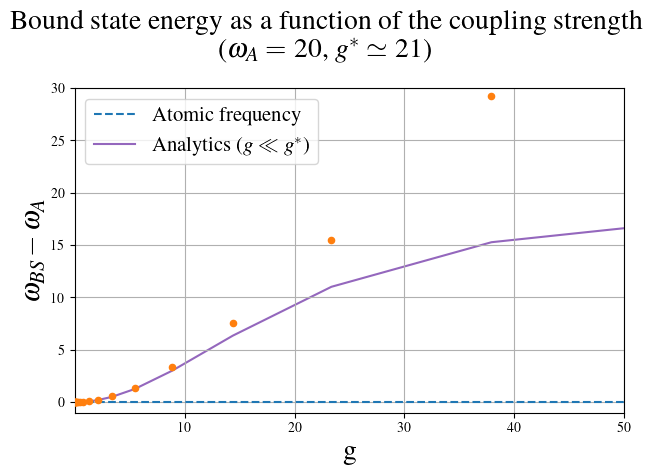

In [8]:
fig = plt.figure(tight_layout=True)
plt.suptitle("Bound state energy as a function of the coupling strength"+
             f"\n ($\omega_A =$ {om_a}, $g^* \simeq$ {g_st:.0f})",fontsize=20)


plt.scatter(g,om_bs-om_a,s=20,c="C1",zorder=3)
plt.hlines(0,0.01,100,ls="--",zorder=2,label="Atomic frequency")
plt.plot(g,om_1,c="C4",zorder=1,label=f"Analytics ($g\ll g^*$)")

plt.xlabel("g",fontsize=20)
plt.ylabel("$\omega_{BS}-\omega_A$",fontsize=20)

#plt.xscale("log")

plt.xlim(0.009,50.)
plt.ylim(-1,30)

plt.grid()
plt.legend(fontsize=15,loc=2)
#plt.savefig("bs/or_20.png")
plt.show()

### Resonant case $\omega_A = \omega_{FB}$

In [9]:
om_a = eps_a + 2*t_bb

In [10]:
g_st = 4*t_bb
g = np.logspace(-2,0.5,n,base=10)
om_1 = np.sqrt(1 - 1/np.sqrt(3))*g

In [11]:
n = 20
om = np.linspace(2.001,5.,1000)

om_bs = np.zeros(n)
for i in range(0,n,1):
    res = g_A(om,eps_a,t_bb,g[i])
    s = res-(om-om_a)
    mask = np.isclose(s,0,atol=1e-2,rtol=0)
    
    om_bs[i] = om[mask][0]

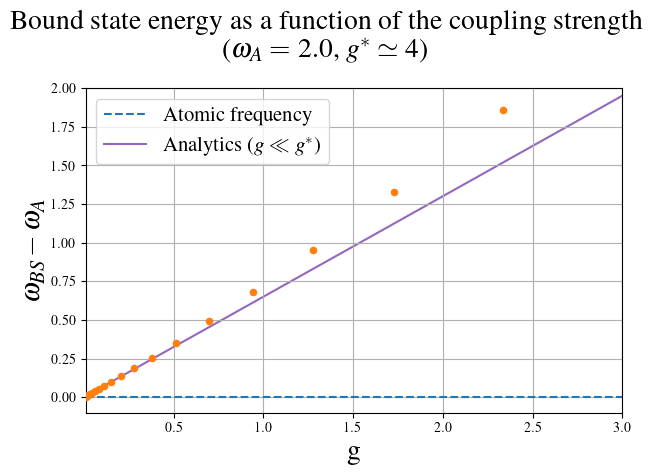

In [12]:
fig = plt.figure(tight_layout=True)
plt.suptitle("Bound state energy as a function of the coupling strength"+
             f"\n ($\omega_A =$ {om_a}, $g^* \simeq$ {g_st:.0f})",fontsize=20)


plt.scatter(g,om_bs-om_a,s=20,c="C1",zorder=3)
plt.hlines(0,0.01,100,ls="--",zorder=2,label="Atomic frequency")
plt.plot(g,om_1,c="C4",zorder=1,label=f"Analytics ($g\ll g^*$)")

plt.xlabel("g",fontsize=20)
plt.ylabel("$\omega_{BS}-\omega_A$",fontsize=20)

#plt.xscale("log")

plt.xlim(0.009,3)
plt.ylim(-0.1,2)

plt.grid()
plt.legend(fontsize=15,loc=2)
#plt.savefig("bs/res.png")
plt.show()

### Photonic Bound State

In [13]:
def amp_A(omega, eps, t, N):
    
    x = (omega-eps+2*t)/(2*t) # x parameter
    wave = np.zeros(2*N) #even pos (0,2,...): B sites
    
    n = N//2
    for i in range(0,N,1):
        wave[2*i:2*i+2] = -(-x+np.sqrt(x**2 - 1))**abs(i-n)
    
    wave /= np.sqrt(x**2 - 1)
    wave[N+1] += 1
    
    wave /= omega - (eps+2*t)
    wave[::2] *= 1 - x + np.sqrt(x**2 -1)
    wave[N::2] = np.flip(wave[:N:2])
    wave[::2] = np.roll(wave[::2],1)
    
    return wave

In [14]:
g = 0.1
om_at = 3
H = Ham_ST(N,eps_a,t_bb,om_at,g,N+1)
eigvals, eigvect = eigh(H)

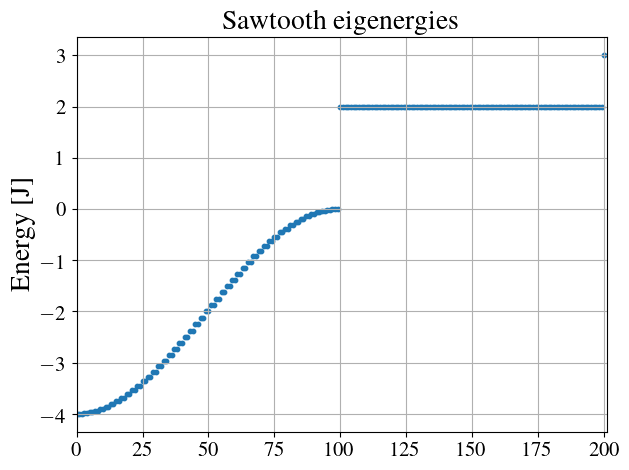

In [15]:
fig, ax = plt.subplots(tight_layout=True)

ax.scatter(np.arange(len(eigvals)),eigvals,s=10)

ax.set_title("Sawtooth eigenergies",fontsize=20)
ax.set_ylabel(r"Energy [J]",fontsize=20)

ax.set_xlim(0,len(eigvals))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.grid()
plt.show()

In [16]:
n = -1
bs = eigvect[:-1,n]
om_bs = eigvals[n]
print("The energy of the BS is",om_bs)
print("The norm of the photonic BS is",norm(bs))
bs /= norm(bs)

The energy of the BS is 3.005609991322073
The norm of the photonic BS is 0.06728848258331341


In [17]:
s = (om_bs-eps_a+2*t_bb)/(2*t_bb)
l = -1/np.log(s-np.sqrt(s**2 - 1))
print("The localization lenght is",l)

The localization lenght is 0.6377459016456993


In [18]:
wave = amp_A(om_bs,eps_a,t_bb,N)

C:\Users\enric\AppData\Local\Temp\ipykernel_16456\2397480537.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([0,0,0.2,0.4,0.6,0.8],fontsize=15)
C:\Users\enric\AppData\Local\Temp\ipykernel_16456\2397480537.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([-0.2,-0.1,0,0.1,0.2,0.3,0.4],fontsize=15)


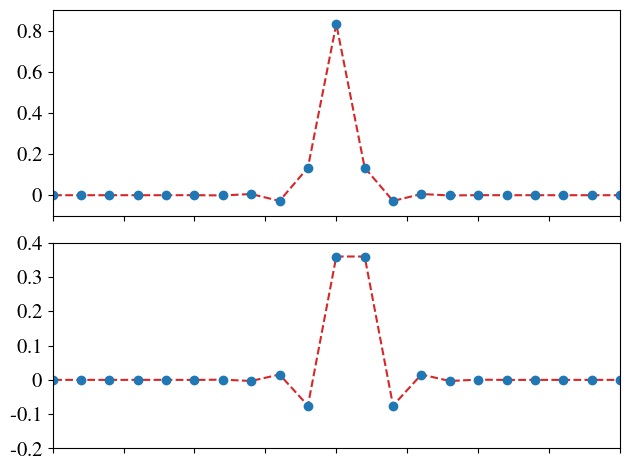

In [19]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=1)

x = np.arange(0,N,1)
fac0 = max(abs(bs[1::2]))/max(abs(wave[1::2]))
ax[0].scatter(x,-bs[1::2],zorder=2)
ax[0].plot(x,fac0*wave[1::2],ls="--",c="C3",zorder=1)

fac1 = max(abs(bs[::2]))/max(abs(wave[::2]))
ax[1].scatter(x,bs[::2],zorder=2)
ax[1].plot(x,wave[::2]*fac1,ls="--",c="C3",zorder=1)

#ax[0].set_title("Atom-photon bound state ($\omega_{BS} =$" + f"{om_bs:.2f}"+")",fontsize=20)
#ax[0].set_ylabel("Amplitude \n on A sites",fontsize=20)
#ax[1].set_ylabel("Amplitude \n on B sites",fontsize=20)

ax[1].set_xlim(40,60)
ax[1].set_xticklabels([])
ax[0].set_ylim(-0.1,0.9)
ax[1].set_ylim(-0.2,0.4)
ax[0].set_yticklabels([0,0,0.2,0.4,0.6,0.8],fontsize=15)
ax[1].set_yticklabels([-0.2,-0.1,0,0.1,0.2,0.3,0.4],fontsize=15)

plt.savefig("bs/BS.png")
plt.show()

## Coupling to a B-site

In [20]:
def g_B(x,eps_a,t_bb,g):
    
    f = 1/np.sqrt(1+4*t_bb/(x-eps_a))
    f /= (x - (eps_a + 2*t_bb))
    
    return f*(g**2)

g_B = np.vectorize(g_B,excluded=["eps_a","t_bb"])

### Off-resonant case $\omega_A \gg \omega_{FB}$

In [21]:
om_a = 20

In [22]:
n = 20
om = np.linspace(2.05,120.,10000)
g = np.logspace(-2,2,n,base=10)

om_bs = np.zeros(n)
for i in range(0,n,1):
    res = g_B(om,eps_a,t_bb,g[i])
    s = res-(om-om_a)
    mask = np.isclose(s,0,atol=1e-2,rtol=0)

    om_bs[i] = om[mask][0]

In [23]:
g_st = np.sqrt((om_a**3)/(om_a + 4*t_bb))

om_1 = (g/om_a)**2 * (om_a + 2*t_bb)

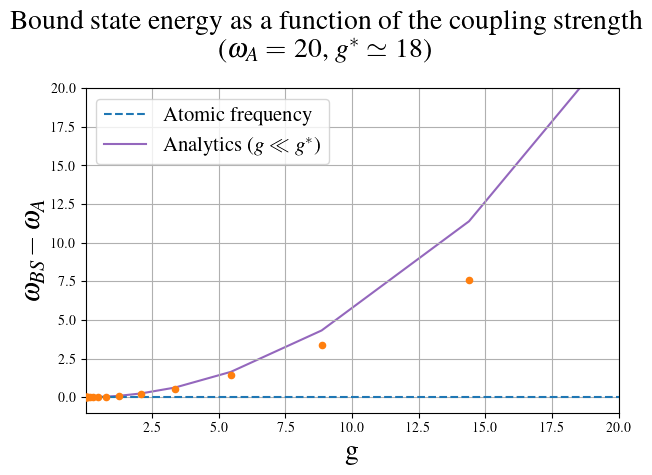

In [24]:
fig = plt.figure(tight_layout=True)
plt.suptitle("Bound state energy as a function of the coupling strength"+
             f"\n ($\omega_A =$ {om_a}, $g^* \simeq$ {g_st:.0f})",fontsize=20)


plt.scatter(g,om_bs-om_a,s=20,c="C1",zorder=3)
plt.hlines(0,0.01,100,ls="--",zorder=2,label="Atomic frequency")
plt.plot(g,om_1,c="C4",zorder=1,label=f"Analytics ($g\ll g^*$)")

plt.xlabel("g",fontsize=20)
plt.ylabel("$\omega_{BS}-\omega_A$",fontsize=20)

#plt.xscale("log")

plt.xlim(0.009,20.)
plt.ylim(-1,20)

plt.grid()
plt.legend(fontsize=15,loc=2)
#plt.savefig("bs/orB_20.png")
plt.show()

### Resonant case $\omega_A = \omega_{FB}$

In [82]:
om_a = eps_a +2 *t_bb

In [87]:
n = 20
om = np.linspace(2.05,50.,1000)
g = np.logspace(-2,0.5,n,base=10)

om_bs = np.zeros(n)
for i in range(0,n,1):
    res = g_B(om,eps_a,t_bb,g[i])
    s = res-(om-om_a)
    mask = np.isclose(s,0,atol=5e-2,rtol=0)

    om_bs[i] = om[mask][0]

In [101]:
g_st = 2*t_bb

om_1 = +g/np.sqrt(2)

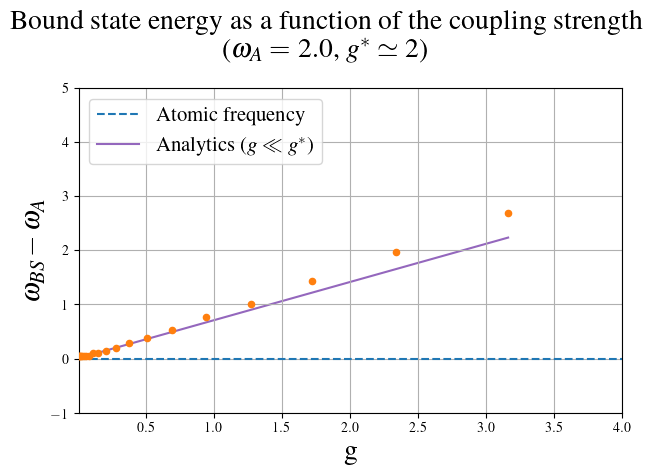

In [103]:
fig = plt.figure(tight_layout=True)
plt.suptitle("Bound state energy as a function of the coupling strength"+
             f"\n ($\omega_A =$ {om_a}, $g^* \simeq$ {g_st:.0f})",fontsize=20)


plt.scatter(g,om_bs-om_a,s=20,c="C1",zorder=3)
plt.hlines(0,0.01,100,ls="--",zorder=2,label="Atomic frequency")
plt.plot(g,om_1,c="C4",zorder=1,label=f"Analytics ($g\ll g^*$)")

plt.xlabel("g",fontsize=20)
plt.ylabel("$\omega_{BS}-\omega_A$",fontsize=20)

#plt.xscale("log")

plt.xlim(0.009,4.)
plt.ylim(-1,5)

plt.grid()
plt.legend(fontsize=15,loc=2)
plt.savefig("bs/resB.png")
plt.show()

### Photonic Bound state

In [220]:
def amp_B(omega, eps, t, N):
    
    x = (omega-eps+2*t)/(2*t) # x parameter
    wave = np.zeros(2*N) #even pos (0,2,...): B sites
    
    n = N//2
    for i in range(0,N,1):
        wave[2*i:2*i+2] = -(-x+np.sqrt(x**2 - 1))**abs(i-n)
    
    wave /= np.sqrt(x**2 - 1)
    
    wave /= omega - (eps+2*t)
    wave[1::2] *= 1 - x + np.sqrt(x**2 -1)
    wave[::2] *= 1-x
    wave[1:N:2] = np.flip(wave[N+1::2])
    
    return wave

In [236]:
g = 0.1
om_at = 2
H = Ham_ST(N,eps_a,t_bb,om_at,g,N)
eigvals, eigvect = eigh(H)

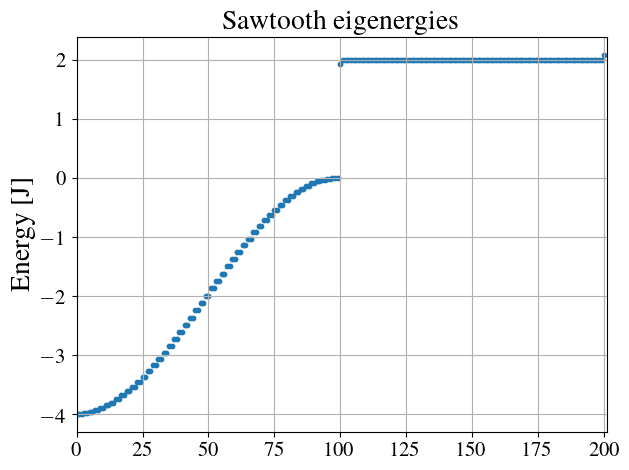

In [237]:
fig, ax = plt.subplots(tight_layout=True)

ax.scatter(np.arange(len(eigvals)),eigvals,s=10)

ax.set_title("Sawtooth eigenergies",fontsize=20)
ax.set_ylabel(r"Energy [J]",fontsize=20)

ax.set_xlim(0,len(eigvals))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.grid()
plt.show()

In [251]:
n = 100
bs = eigvect[:-1,n]
om_bs = eigvals[n]
print("The energy of the BS is",om_bs)
print("The norm of the photonic BS is",norm(bs))
bs /= norm(bs)

The energy of the BS is 1.9245052497263817
The norm of the photonic BS is 0.7094285662950999


In [252]:
s = (om_bs-eps_a+2*t_bb)/(2*t_bb)
l = -1/np.log(s-np.sqrt(s**2 - 1))
print("The localization lenght is",l)

The localization lenght is 0.7722693959811242


In [253]:
wave = amp_B(om_bs,eps_a,t_bb,N)

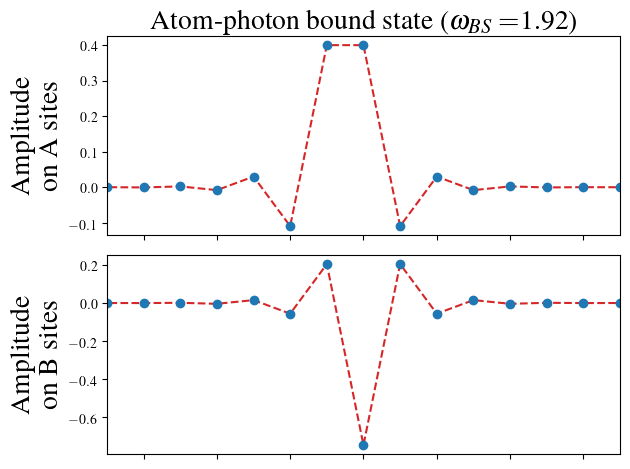

In [255]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=1)

x = np.arange(0,100,1)
fac0 = max(abs(bs[1::2]))/max(abs(wave[1::2]))
ax[0].scatter(x,bs[1::2],zorder=2)
ax[0].plot(x,fac0*wave[1::2],ls="--",c="C3",zorder=1)

fac1 = max(abs(bs[::2]))/max(abs(wave[::2]))
ax[1].scatter(x,bs[::2],zorder=2)
ax[1].plot(x,wave[::2]*fac1,ls="--",c="C3",zorder=1)

ax[0].set_title("Atom-photon bound state ($\omega_{BS} =$" + f"{om_bs:.2f}"+")",fontsize=20)
ax[0].set_ylabel("Amplitude \n on A sites",fontsize=20)
ax[1].set_ylabel("Amplitude \n on B sites",fontsize=20)

ax[1].set_xlim(43,57)
ax[1].set_xticklabels([])

plt.savefig("bs/BS_B_le.png")
plt.show()

# Isolating the FB

In [25]:
N = 200
# On-site energies
eps_a = eps_b = 0.

# Hopping terms
t_aa = 0
t_bb = 1.
t_ab = t_bb*np.sqrt(2)

om_fb = eps_a + 2*t_bb

In [26]:
omega0 = 3. #atom frequency
g = 0.1 #atom-cavity coupling

In [27]:
x = np.arange(0,N,1)
l = 0.3 # localization lenght

vec_b = -np.sqrt(2)*np.exp(-abs(x-(N//2))/l)/l
vec_a = np.zeros(N)
vec_a[:N//2] = np.exp(-abs(x[:N//2]-(N//2)+1)/l)/l + np.exp(-abs(x[:N//2]-(N//2))/l)/l
vec_a[N//2:] = np.flip(vec_a[:N//2])

In [28]:
c = np.sqrt(np.sum(vec_a**2) + np.sum(vec_b**2))

In [29]:
vec_a[np.where(vec_a/c < 1e-2)] = 0.
vec_b[np.where(abs(vec_b)/c < 1e-2)] = 0.

In [30]:
H = np.diag([eps_b/2,eps_a/2]*N + [omega0/2])
H += np.diag([-t_ab]*(2*N -1) + [0],k=1)
H += np.diag([-t_bb,-t_aa]*(N-1) + [0],k=2)

H[0,2*N-2] -= t_bb
H[0,2*N-1] -= t_ab

H[:-1:2,-1] = vec_b*g/c
H[1:-1:2,-1] = vec_a*g/c

H += np.conjugate(H.transpose())

In [31]:
eigvals, eigvect = eigh(H)

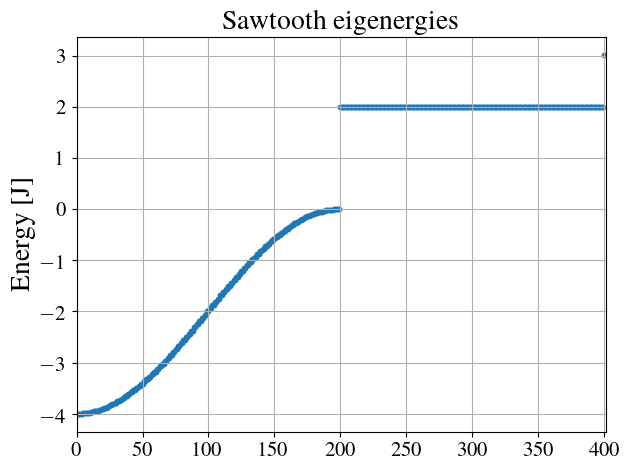

In [32]:
fig, ax = plt.subplots(tight_layout=True)

ax.scatter(np.arange(len(eigvals)),eigvals,s=10)

ax.set_title("Sawtooth eigenergies",fontsize=20)
ax.set_ylabel(r"Energy [J]",fontsize=20)

ax.set_xlim(0,len(eigvals))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.grid()
plt.show()

We observe two bound states with energy which are solution of the exact equation
\begin{equation}
    (\omega-\omega_a)(\omega-\omega_{FB}) = g^2
\end{equation}

In [33]:
n = -1
bs1 = eigvect[:-1,n]
om_bs1 = eigvals[n]
pred1 = (omega0+om_fb)/2 + 0.5*np.sqrt((omega0-om_fb)**2 + 4 * g**2)
print(f"BS energy: {om_bs1:.5f}")
print(f"Predicted energy: {pred1:.5f}")
print(f"Discrepancy [%]: {(abs(1-pred1/om_bs1)*100):.1e}")
print(f"The norm of the photonic BS is {norm(bs1):.5f}")
bs1 /= norm(bs1)

BS energy: 3.00990
Predicted energy: 3.00990
Discrepancy [%]: 8.9e-07
The norm of the photonic BS is 0.09854


In [34]:
n = N
bs2 = eigvect[:-1,n]
om_bs2 = eigvals[n]
pred2 = (omega0+om_fb)/2 - 0.5*np.sqrt((omega0-om_fb)**2 + 4 * g**2)
print(f"BS energy: {om_bs2:.5f}")
print(f"Predicted energy: {pred2:.5f}")
print(f"Discrepancy [%]: {(abs(1-pred2/om_bs2)*100):.1e}")
print(f"The norm of the photonic BS is {norm(bs2):.5f}")
bs2 /= norm(bs2)

BS energy: 1.99010
Predicted energy: 1.99010
Discrepancy [%]: 1.4e-06
The norm of the photonic BS is 0.99513


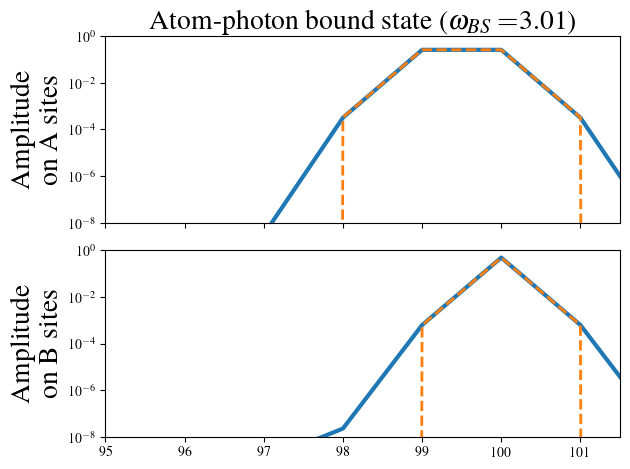

In [35]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=1)

ax[0].plot(bs1[1::2]**2,zorder=2,lw=3)
ax[1].plot(bs1[::2]**2,zorder=1,lw=3)

fac = np.max(bs1[1::2]**2)/np.max(vec_a**2)
ax[0].plot(fac*vec_a**2,ls="--",lw=2)

fac = np.max(bs1[::2]**2)/np.max(vec_b**2)
ax[1].plot(fac*vec_b**2,ls="--",lw=2)

ax[0].set_title("Atom-photon bound state ($\omega_{BS} =$" + f"{om_bs1:.2f}"+")",fontsize=20)
ax[0].set_ylabel("Amplitude \n on A sites",fontsize=20)
ax[1].set_ylabel("Amplitude \n on B sites",fontsize=20)

ax[1].set_xlim(N//2-5,N//2+5*l)
#ax[1].set_xlim(N//2-3,N//2+3)

ax[0].set_yscale("log")
ax[0].set_ylim(1e-8,1)
ax[1].set_yscale("log")
ax[1].set_ylim(1e-8,1)

#plt.savefig(f"giant/bs/{omega0:.0f}_l{l:.0f}.png")
plt.show()

## Coupling to a CLS

In [31]:
omega0 = 3. #atom frequency
g = 0.1 #atom-cavity coupling

In [32]:
H = np.diag([eps_b/2,eps_a/2]*N + [omega0/2])
H += np.diag([-t_ab]*(2*N -1) + [0],k=1)
H += np.diag([-t_bb,-t_aa]*(N-1) + [0],k=2)

H[0,2*N-2] -= t_bb
H[0,2*N-1] -= t_ab

H[N,-1] += g/np.sqrt(2)
H[N-1,-1] -= g/2
H[N+1,-1] -= g/2

H += np.conjugate(H.transpose())

In [33]:
eigvals, eigvect = eigh(H)

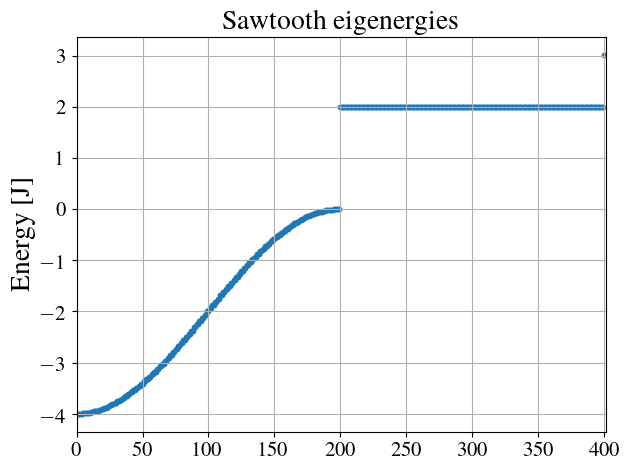

In [34]:
fig, ax = plt.subplots(tight_layout=True)

ax.scatter(np.arange(len(eigvals)),eigvals,s=10)

ax.set_title("Sawtooth eigenergies",fontsize=20)
ax.set_ylabel(r"Energy [J]",fontsize=20)

ax.set_xlim(0,len(eigvals))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.grid()
#plt.savefig("spectrum_sawtooth.png")
plt.show()

In [35]:
n = -1
bs1 = eigvect[:-1,n]
om_bs1 = eigvals[n]
pred1 = (omega0+om_fb)/2 + 0.5*np.sqrt((omega0-om_fb)**2 + 4 * g**2)
print(f"BS energy: {om_bs1:.5f}")
print(f"Predicted energy: {pred1:.5f}")
print(f"Discrepancy [%]: {(abs(1-pred1/om_bs1)*100):.1e}")
print(f"The norm of the photonic BS is {norm(bs1):.5f}")
bs1 /= norm(bs1)

BS energy: 3.00990
Predicted energy: 3.00990
Discrepancy [%]: 2.0e-13
The norm of the photonic BS is 0.09854


In [36]:
n = N
bs2 = eigvect[:-1,n]
om_bs2 = eigvals[n]
pred2 = (omega0+om_fb)/2 - 0.5*np.sqrt((omega0-om_fb)**2 + 4 * g**2)
print(f"BS energy: {om_bs2:.5f}")
print(f"Predicted energy: {pred2:.5f}")
print(f"Discrepancy [%]: {(abs(1-pred2/om_bs2)*100):.1e}")
print(f"The norm of the photonic BS is {norm(bs2):.5f}")
bs2 /= norm(bs2)

BS energy: 1.99010
Predicted energy: 1.99010
Discrepancy [%]: 8.9e-14
The norm of the photonic BS is 0.99513


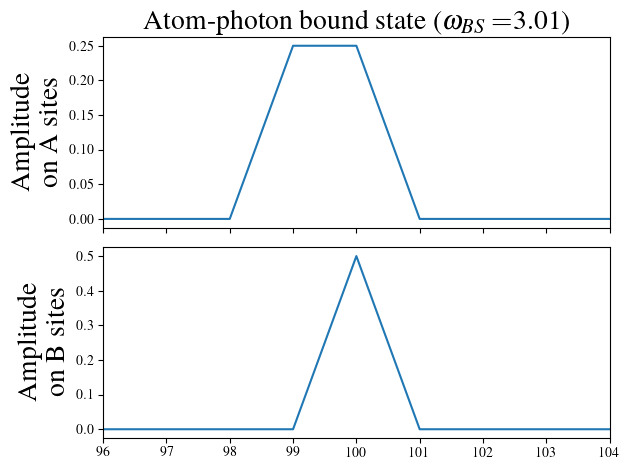

In [37]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=1)

ax[0].plot(bs1[1::2]**2,zorder=2)
ax[1].plot(bs1[::2]**2,zorder=1)

ax[0].set_title("Atom-photon bound state ($\omega_{BS} =$" + f"{om_bs1:.2f}"+")",fontsize=20)
ax[0].set_ylabel("Amplitude \n on A sites",fontsize=20)
ax[1].set_ylabel("Amplitude \n on B sites",fontsize=20)

ax[1].set_xlim(N//2-4,N//2+4)

plt.show()